In [96]:
import sklearn
import warnings
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from statistics import median, mean
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay, make_scorer, roc_curve
from sklearn.model_selection import train_test_split,cross_val_score, cross_validate, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier,RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.impute import KNNImputer 


In [2]:
dir = "data/"

employee_survey = pd.read_csv(dir + "employee_survey_data.csv")
general = pd.read_csv(dir + "general_data.csv")
manager_survey = pd.read_csv(dir + "manager_survey_data.csv")
in_time = pd.read_csv(dir + "in_time.csv")
out_time = pd.read_csv(dir + "out_time.csv")

# Définition des variables globales

Calcul du nombre total d'employés

In [3]:
nbEmploye = employee_survey["EmployeeID"].max()
print("Il y a", nbEmploye, "employés dans le dataset")

Il y a 4410 employés dans le dataset


# Pré-analyse des données

## Employee_survey.csv

### Données contenues dans le set

Tout d'abord on regarde les données contenues dans le set ainsi que leurs types, ici on remarque que les données sont de type int64 et float64, donc aucun problème pour les faire entrer dans notre modèle de machine learning.

In [4]:
employee_survey.head()

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1,3.0,4.0,2.0
1,2,3.0,2.0,4.0
2,3,2.0,2.0,1.0
3,4,4.0,4.0,3.0
4,5,4.0,1.0,3.0


In [5]:
employee_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeID               4410 non-null   int64  
 1   EnvironmentSatisfaction  4385 non-null   float64
 2   JobSatisfaction          4390 non-null   float64
 3   WorkLifeBalance          4372 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 137.9 KB


### Anaylse des données vides

Ensuite on regarde la proportion de données vides pour réfléchir à une stratégie de remplacement,ici il y a un nombre conséquent de données manquantes donc il va falloir remplacer les données par des valeurs et non supprimer les lignes qui les contiennent.

In [6]:
employee_survey.isnull().sum()

EmployeeID                  0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
dtype: int64

### Répartition des notes

Pour ce qui est de la répartition on vérifie qu'il n'exsiste pas de valeurs aberrantes
Ce qui n'est pas le cas ici

<Axes: >

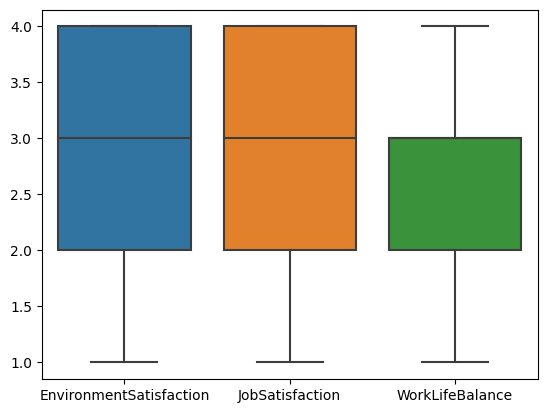

In [7]:
employee_survey_anonyme = employee_survey.drop(["EmployeeID"], axis=1, inplace=False)
sns.boxplot(data=employee_survey_anonyme)


### Tendance des mauvais résultats

On regarde tout d'abord le nombre de gens qui sont insatisfait le l'environnement de travail et on remarque qu'ils représentent 38,5% des employés

In [9]:
BadEnvironmentSatisfaction = employee_survey[employee_survey['EnvironmentSatisfaction']<2.1].count()
print(BadEnvironmentSatisfaction['EnvironmentSatisfaction'] / nbEmploye * 100)
BadEnvironmentSatisfaction


38.57142857142858


EmployeeID                 1701
EnvironmentSatisfaction    1701
JobSatisfaction            1694
WorkLifeBalance            1685
dtype: int64

On fait la même chose pour la satisfaction sur leurs travail et on obtient des résultats similaires, ce qui confirme les boîtes a moustache

In [10]:
BadJobSatisfaction = employee_survey[employee_survey['JobSatisfaction']<2.1].count()
print(BadJobSatisfaction['JobSatisfaction'] / nbEmploye * 100)
BadJobSatisfaction

38.54875283446712


EmployeeID                 1700
EnvironmentSatisfaction    1694
JobSatisfaction            1700
WorkLifeBalance            1687
dtype: int64

Enfin on regarde l'équilibre entre la vie privée et professionelle, dans ce cas on obtient 28.5% des employés

In [11]:
BadWorkLifeBalance = employee_survey[employee_survey['WorkLifeBalance']<2.1].count()
print(BadWorkLifeBalance['WorkLifeBalance'] / nbEmploye * 100)
BadWorkLifeBalance

28.52607709750567


EmployeeID                 1258
EnvironmentSatisfaction    1250
JobSatisfaction            1254
WorkLifeBalance            1258
dtype: int64

Si on essaie de regarder les employés qui une balance mauvaise, et une satisfaction de leur travail et de leur environnement de travail faible on obtient 178 personne avec une très mauvaise expérience

In [12]:
BadEnvironmentSatisfaction = employee_survey[employee_survey['EnvironmentSatisfaction']<2.1]
BadSatisfaction = BadEnvironmentSatisfaction[BadEnvironmentSatisfaction['JobSatisfaction']<2.1]
BadAll = BadSatisfaction[BadSatisfaction['WorkLifeBalance']<2.1]
BadAll["EmployeeID"].count()

178

## General.csv

### Données contenue dans le set

On regarde les types de données, et ici on remarque que l'on a des données de types int64 et float64 mais aussi des données de type object, ce qui va nous poser problème pour les mettre dans notre modèle de machine learning.

In [13]:
general.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,4.0,Y,12,8,2,9.0,2,6,0,4


In [14]:
general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

### Analyse des données vides

Pour ce qui est des données nulles on remarque que les données sont très peu nombreuses, mais elles sont aussi facilement remplaçable. Le but ici est de maximiser le nombres de données sachant que le dataset est déjà assez petit.

In [15]:
general.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

### Analyse générales

#### Nombres de personnes qui ont quitté l'entreprise en 2016

In [16]:
peopleLeft = general[general["Attrition"] == "Yes"]
print("Number of people who left the company:", peopleLeft.shape[0], "out of", nbEmploye, "employees")
print("Approx", round(peopleLeft.shape[0] / nbEmploye * 100, 2), "% of the employees left the company")

Number of people who left the company: 711 out of 4410 employees
Approx 16.12 % of the employees left the company


### Histogrammes

On affiche les histogrammes des différentes variables pour voir leur répartition et déceler d'éventiuel valeurs bornées.

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'DistanceFromHome'}>,
        <Axes: title={'center': 'Education'}>],
       [<Axes: title={'center': 'JobLevel'}>,
        <Axes: title={'center': 'MonthlyIncome'}>,
        <Axes: title={'center': 'NumCompaniesWorked'}>],
       [<Axes: title={'center': 'PercentSalaryHike'}>,
        <Axes: title={'center': 'TotalWorkingYears'}>,
        <Axes: title={'center': 'TrainingTimesLastYear'}>],
       [<Axes: title={'center': 'YearsAtCompany'}>,
        <Axes: title={'center': 'YearsSinceLastPromotion'}>,
        <Axes: title={'center': 'YearsWithCurrManager'}>]], dtype=object)

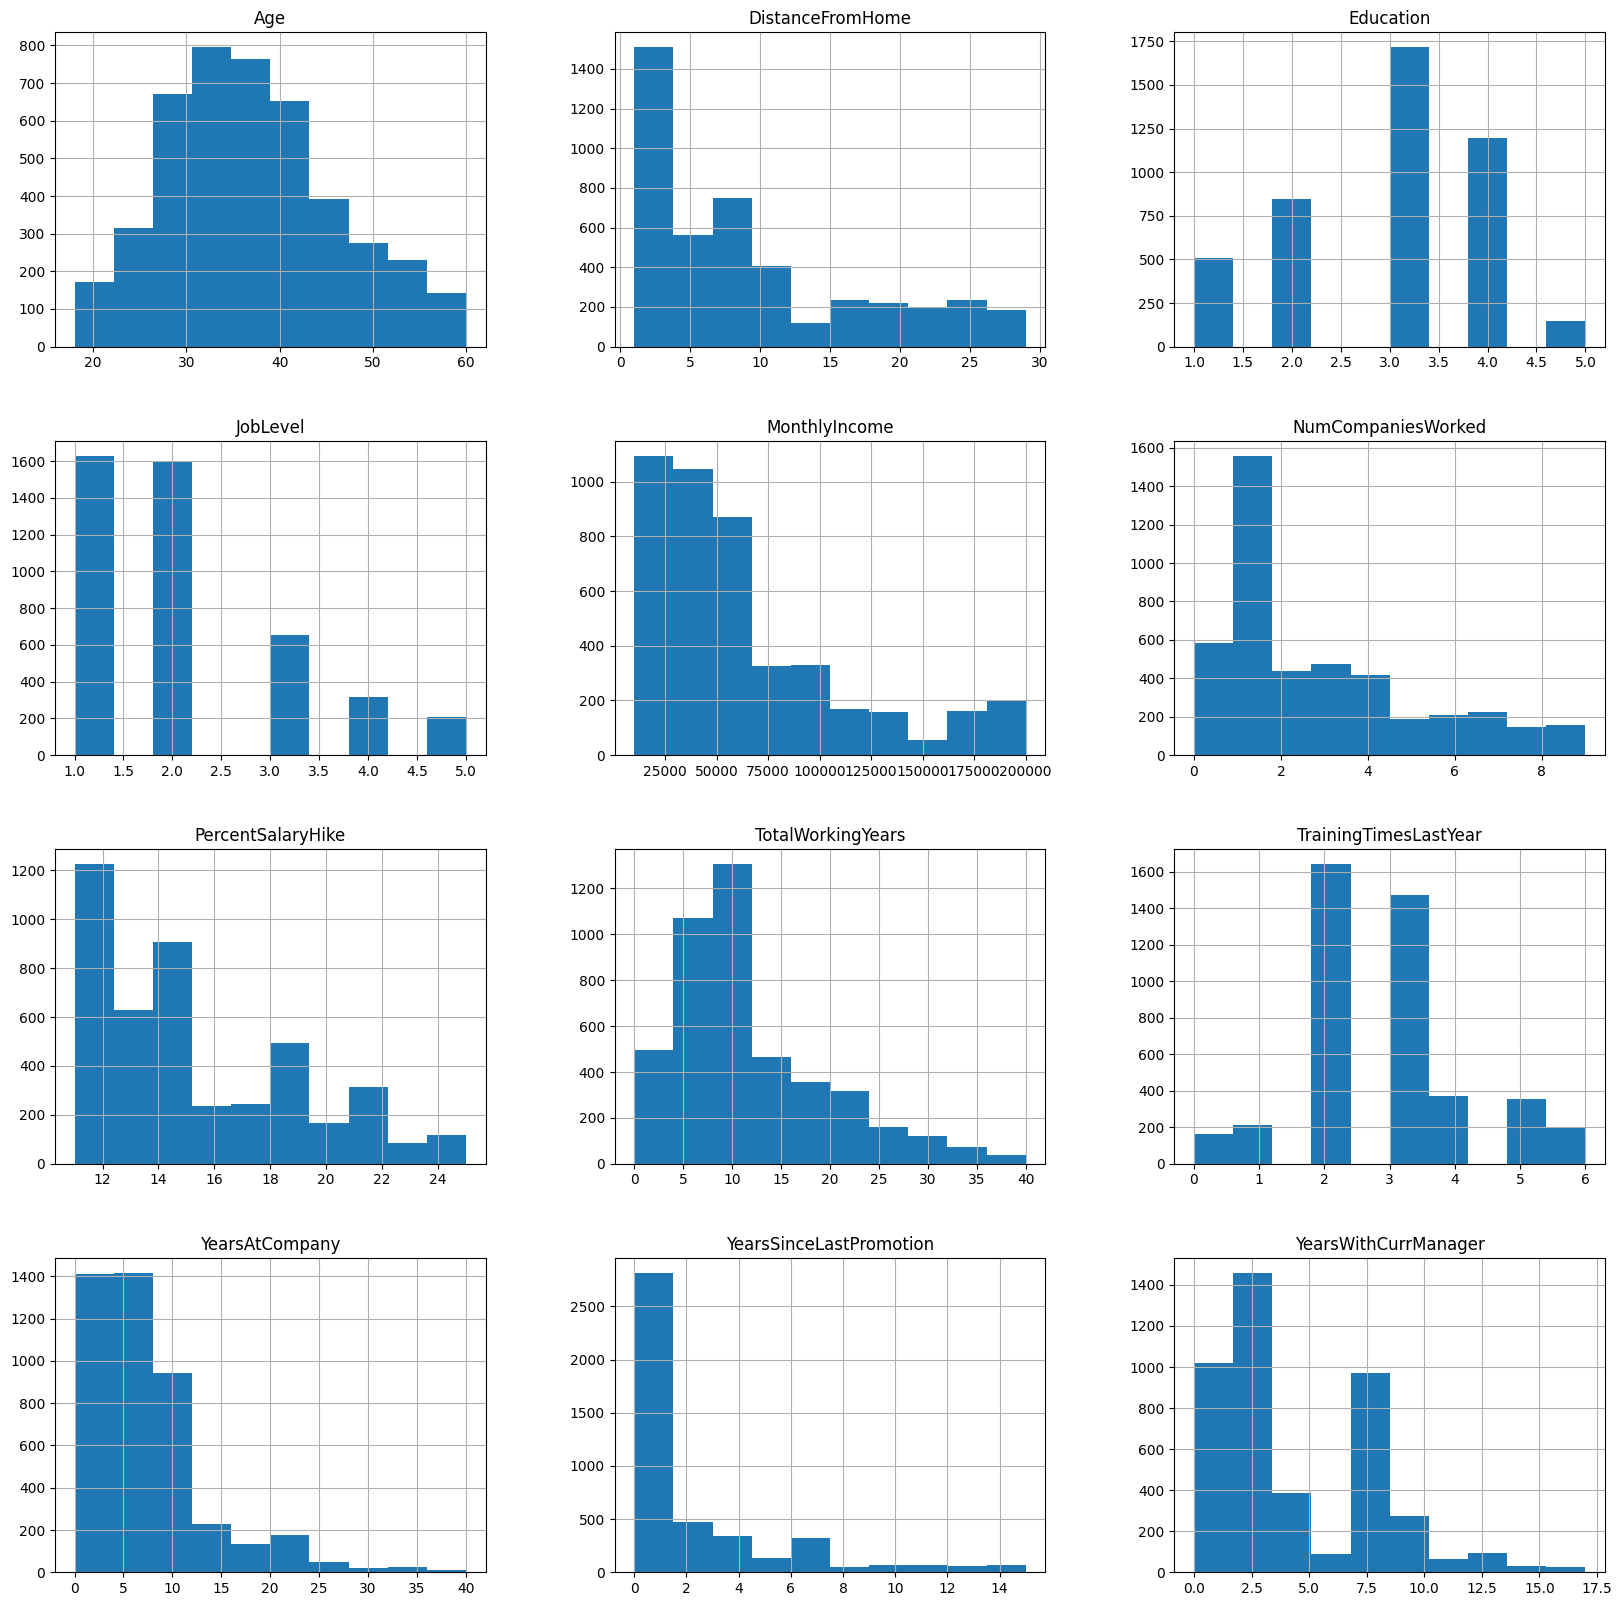

In [17]:
general.filter(items= ["Age","DistanceFromHome","Education","JobLevel", "MonthlyIncome", "NumCompaniesWorked", "PercentSalaryHike", "TotalWorkingYears", "TrainingTimesLastYear", "YearsAtCompany", "YearsSinceLastPromotion", "YearsWithCurrManager"]).hist(figsize=(20,20))

### Boîtes à moustaches

On affiche les histogrammes des différentes variables pour voir leur répartition et déceler d'éventiuel valeurs aberrantes.
Pour Age, DistanceFromHome, Education, JobLevel, PercentSalaryHike on remarque que les données sont assez resserées donc on peut les garder tel quel.
Pour MonthlyIncome, YearsAtCompany, YearsSinceLastPromotion, YearsWithCurrManager, TotalWorkingYears, NumCompaniesWorked on remarque des données aberrantes.

Pour NumCompaniesWorked, YearsWithCurrManager le peu de données aberrantes nous permet de ne pas les modifier.
Pour les autres nous allons devoir les **Strandardiser**.

<Axes: >

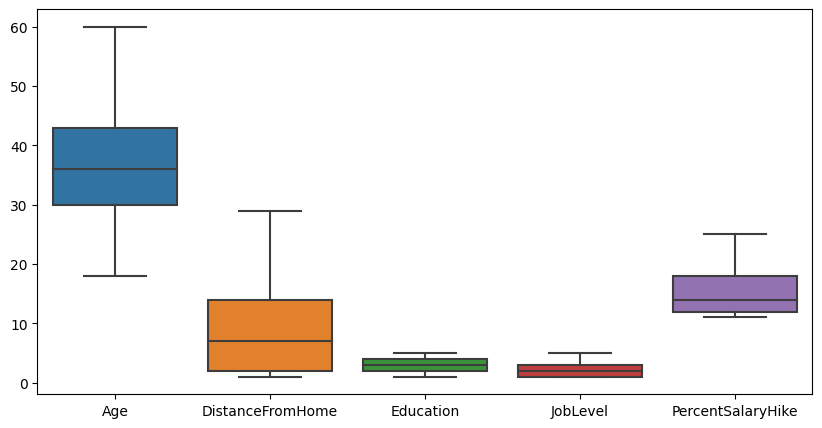

In [88]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=general.filter(items= ["Age","DistanceFromHome","Education","JobLevel", "PercentSalaryHike"]))

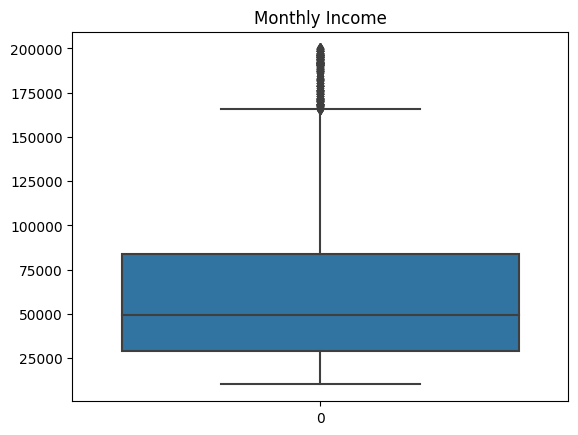

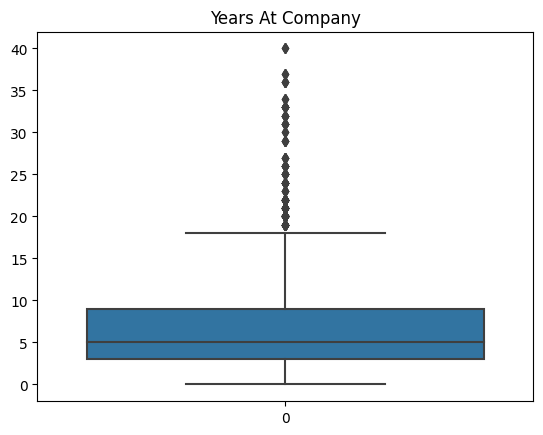

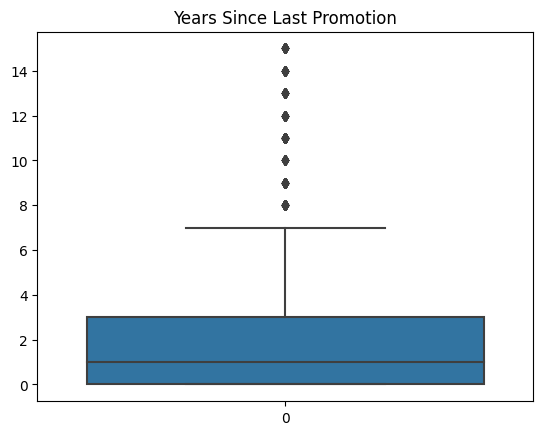

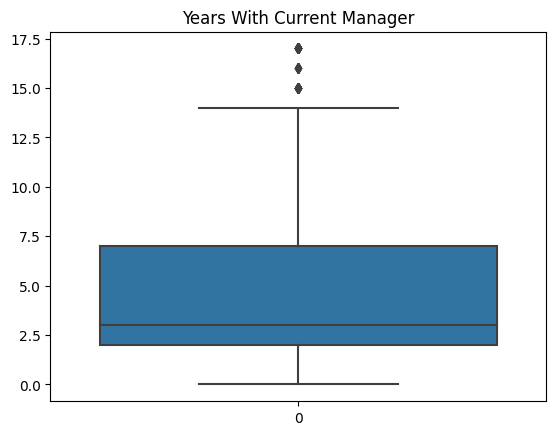

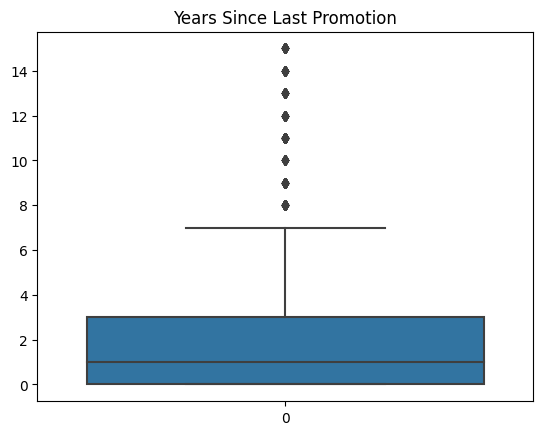

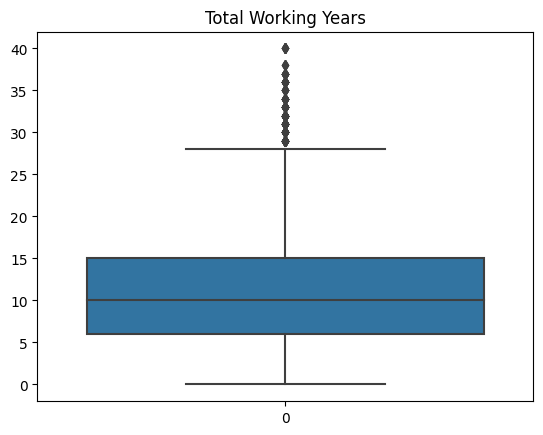

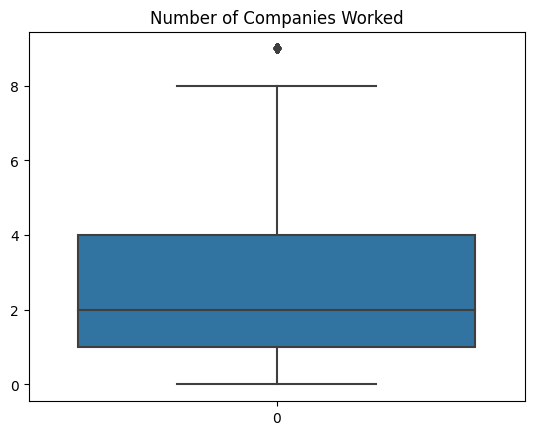

In [89]:
sns.boxplot(data=general["MonthlyIncome"])
plt.title("Monthly Income")
plt.show()

sns.boxplot(data=general["YearsAtCompany"])
plt.title("Years At Company")
plt.show()

sns.boxplot(data=general["YearsSinceLastPromotion"])
plt.title("Years Since Last Promotion")
plt.show()

sns.boxplot(data=general["YearsWithCurrManager"])
plt.title("Years With Current Manager")
plt.show()

sns.boxplot(data=general["YearsSinceLastPromotion"])
plt.title("Years Since Last Promotion")
plt.show()

sns.boxplot(data=general["TotalWorkingYears"])
plt.title("Total Working Years")
plt.show()

sns.boxplot(data=general["NumCompaniesWorked"])
plt.title("Number of Companies Worked")
plt.show()


## Manager survey.csv

### Données contenue dans le set

Pour manager survey, toutes les données sont de type int64 donc pas de problème pour les mettre dans notre modèle de machine learning.

In [18]:
manager_survey.head()

,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3
1,2,2,4
2,3,3,3
3,4,2,3
4,5,3,3


In [19]:
manager_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   EmployeeID         4410 non-null   int64
 1   JobInvolvement     4410 non-null   int64
 2   PerformanceRating  4410 non-null   int64
dtypes: int64(3)
memory usage: 103.5 KB


### Analyse des données vides

Il n'y aura pas de problèmes non plus pour les données vides, car il n'y en a pas.

In [20]:
manager_survey.isnull().sum()

EmployeeID           0
JobInvolvement       0
PerformanceRating    0
dtype: int64

### Analyse générale

On remarque cependant qu'il y a des données assez étranges, le PerformanceRating est une note sur 4, mais il y a des notes de 3, 4 ce qui est assez bizarre.
Mais en partant du fait que le jeu de donnée est généré a la main, ce problème est expliquable.

<Axes: >

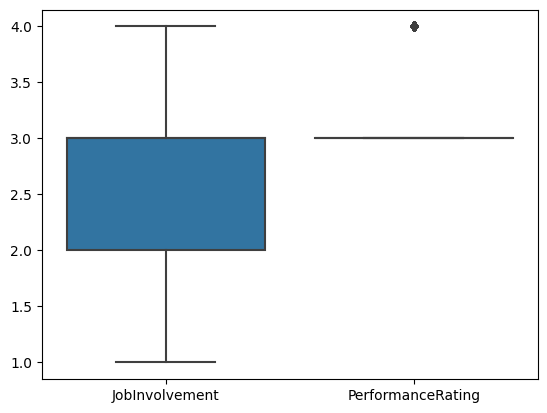

In [21]:
manager_survey_anonyme = manager_survey.drop(["EmployeeID"], axis=1, inplace=False)
sns.boxplot(data=manager_survey_anonyme)

## In Time.csv

### Données contenues dans le dataset

On remaque que les données sont des dates donc pas besoin de modifier les types de données.

In [22]:
in_time.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,...,NaN,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,NaN,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,NaN,2015-01-02 10:15:44,2015-01-05 10:21:05,NaN,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,...,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,NaN,NaN,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
2,3,NaN,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,...,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,NaN,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39
3,4,NaN,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,...,2015-12-18 10:17:38,2015-12-21 09:58:21,2015-12-22 10:04:25,2015-12-23 10:11:46,2015-12-24 09:43:15,NaN,2015-12-28 09:52:44,2015-12-29 09:33:16,2015-12-30 10:18:12,2015-12-31 10:01:15
4,5,NaN,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,...,2015-12-18 09:58:35,2015-12-21 10:03:41,2015-12-22 10:10:30,2015-12-23 10:13:36,2015-12-24 09:44:24,NaN,2015-12-28 10:05:15,2015-12-29 10:30:53,2015-12-30 09:18:21,2015-12-31 09:41:09


### Analyse des données vides

Pour ce qui est des données manquantes, ce sont des journées ou les employés ne sont pas venus, donc cela va devenir un indicateur supplémentaire pour notre modèle.

In [23]:
print("Par date")
print(in_time.isnull().sum())
print("Par employé")
print(in_time.isnull().sum(axis=1))

Par date
Unnamed: 0       0
2015-01-01    4410
2015-01-02     209
2015-01-05     206
2015-01-06     228
              ... 
2015-12-25    4410
2015-12-28     234
2015-12-29     230
2015-12-30     265
2015-12-31     213
Length: 262, dtype: int64
Par employé
0       29
1       25
2       19
3       26
4       16
        ..
4405    18
4406    20
4407    30
4408    20
4409    29
Length: 4410, dtype: int64


### Répartition des données

On analyse la répartition des données pour vérifier qu'il n'y a pas de données aberrantes. Dans notre cas les données sont tout a fait correctes.

<Axes: >

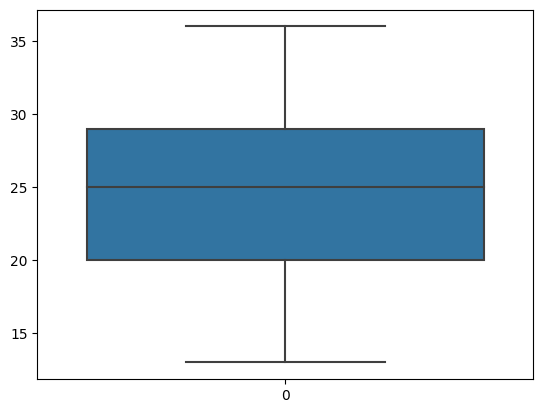

In [24]:
sns.boxplot(in_time.isnull().sum(axis=1))

## Out Time.csv

### Données contenues dans le set

Même chose que pour In Time, les données sont toutes de type dates donc pas besoin de modifier quoi que ce soit.

In [25]:
out_time.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 16:56:15,2015-01-05 17:20:11,2015-01-06 17:19:05,2015-01-07 16:34:55,2015-01-08 17:08:32,2015-01-09 17:38:29,2015-01-12 16:58:39,2015-01-13 18:02:58,...,NaN,2015-12-21 17:15:50,2015-12-22 17:27:51,2015-12-23 16:44:44,2015-12-24 17:47:22,NaN,2015-12-28 18:00:07,2015-12-29 17:22:30,2015-12-30 17:40:56,2015-12-31 17:17:33
1,2,NaN,2015-01-02 18:22:17,2015-01-05 17:48:22,NaN,2015-01-07 17:09:06,2015-01-08 17:34:04,2015-01-09 16:52:29,2015-01-12 17:36:48,2015-01-13 18:00:13,...,2015-12-18 18:31:28,2015-12-21 17:34:16,2015-12-22 18:16:35,2015-12-23 17:38:18,NaN,NaN,2015-12-28 17:08:38,2015-12-29 17:54:46,2015-12-30 18:31:35,2015-12-31 17:40:58
2,3,NaN,2015-01-02 16:59:14,2015-01-05 17:06:46,2015-01-06 16:38:32,2015-01-07 16:33:21,2015-01-08 17:24:22,2015-01-09 16:57:30,2015-01-12 17:28:54,2015-01-13 17:21:25,...,2015-12-18 17:02:23,2015-12-21 17:20:17,2015-12-22 16:32:50,2015-12-23 16:59:43,2015-12-24 16:58:25,NaN,2015-12-28 16:43:31,2015-12-29 17:09:56,2015-12-30 17:06:25,2015-12-31 17:15:50
3,4,NaN,2015-01-02 17:25:24,2015-01-05 17:14:03,2015-01-06 17:07:42,2015-01-07 16:32:40,2015-01-08 16:53:11,2015-01-09 17:19:47,2015-01-12 17:13:37,2015-01-13 17:11:45,...,2015-12-18 17:55:23,2015-12-21 16:49:09,2015-12-22 17:24:00,2015-12-23 17:36:35,2015-12-24 16:48:21,NaN,2015-12-28 17:19:34,2015-12-29 16:58:16,2015-12-30 17:40:11,2015-12-31 17:09:14
4,5,NaN,2015-01-02 18:31:37,2015-01-05 17:49:15,2015-01-06 17:26:25,2015-01-07 17:37:59,2015-01-08 17:59:28,2015-01-09 17:44:08,2015-01-12 18:51:21,2015-01-13 18:14:58,...,2015-12-18 17:52:48,2015-12-21 17:43:35,2015-12-22 18:07:57,2015-12-23 18:00:49,2015-12-24 17:59:22,NaN,2015-12-28 17:44:59,2015-12-29 18:47:00,2015-12-30 17:15:33,2015-12-31 17:42:14


### Analyse des données vides

Ici aussi on obtient les même types de valeurs nulles donc pas de problème.

In [26]:
print("Par date")
print(out_time.isnull().sum())
print("Par employé")
print(out_time.isnull().sum(axis=1))


Par date
Unnamed: 0       0
2015-01-01    4410
2015-01-02     209
2015-01-05     206
2015-01-06     228
              ... 
2015-12-25    4410
2015-12-28     234
2015-12-29     230
2015-12-30     265
2015-12-31     213
Length: 262, dtype: int64
Par employé
0       29
1       25
2       19
3       26
4       16
        ..
4405    18
4406    20
4407    30
4408    20
4409    29
Length: 4410, dtype: int64


### Répartition des données

Ici aussi les données sont cohérentes, il n'y aura pas de standardisation à mettre en place.

<Axes: >

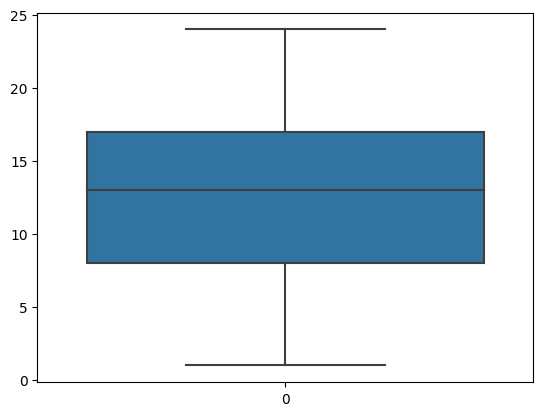

In [91]:

sns.boxplot(out_time.isnull().sum(axis=1))

# Préparation des données

## Numérisation

#### Variables discrètes hierarchiques

Ensuite, on remplace les valeurs dans "BusinessTravel" avec l'"OrdinalEncoder" car il y a un ordre hiérarchique entre les données

In [28]:
ord_enc = OrdinalEncoder(categories=[['Non-Travel','Travel_Rarely','Travel_Frequently']])
encoded = ord_enc.fit_transform(general[["BusinessTravel"]])
general.drop('BusinessTravel', axis=1)
general = general.assign(BusinessTravel = encoded) 

In [29]:
ord_enc = OrdinalEncoder(categories=[['No','Yes']])
encoded = ord_enc.fit_transform(general[["Attrition"]])
general.drop('Attrition', axis=1)
general = general.assign(Attrition = encoded) 

In [30]:
ord_enc = OrdinalEncoder(categories=[['N','Y']])
encoded = ord_enc.fit_transform(general[["Over18"]])
general.drop('Over18', axis=1)
general = general.assign(Over18 = encoded) 

#### Variables discrètes indépendantes
Ensuite on remplace les valeurs dans "Department" avec le "OneHotEncoder" car il n'y a pas de hiérarchie entre les valeurs

In [31]:
one_enc = OneHotEncoder()
encoded = one_enc.fit_transform(general[['Department']])
dpt_enc = pd.DataFrame(encoded.toarray())
dpt_enc = dpt_enc.rename(columns={0:'Department_HR', 1:'Department_Research & Development', 2:'Department_Sales'})
general.drop('Department', axis=1, inplace=True)
general = pd.concat([general, dpt_enc], axis=1)

In [32]:
one_enc = OneHotEncoder()
encoded = one_enc.fit_transform(general[['EducationField']])
edu_enc = pd.DataFrame(encoded.toarray())
edu_enc = edu_enc.rename(columns={
    0:'Education_Human Resources', 
    1:'Education_Life Sciences', 
    2:'Education_Marketing', 
    3:'Education_Medical', 
    4:'Education_Other', 
    5:'Education_Technical Degreee'})
general.drop('EducationField', axis=1, inplace=True)
general = pd.concat([general, edu_enc], axis=1)

In [33]:
one_enc = OneHotEncoder()
encoded = one_enc.fit_transform(general[['Gender']])
gen_enc = pd.DataFrame(encoded.toarray())
gen_enc = gen_enc.rename(columns={0:'Female', 1:'Male'})
general.drop('Gender', axis=1, inplace=True)
general = pd.concat([general, gen_enc], axis=1)

In [34]:
one_enc = OneHotEncoder()
encoded = one_enc.fit_transform(general[['JobRole']])
job_enc = pd.DataFrame(encoded.toarray())
job_enc = job_enc.rename(columns={
    0:'Job_Healthcare Representative', 
    1:'Job_Human Resources', 
    2:'Job_Laboratory Technician', 
    3:'Job_Manager', 
    4:'Job_Manufacturing Director',
    5:'Job_Research Director',
    6:'Job_Research Scientist',
    7:'Job_Sales Executive',
    8:'Job_Sales Representative'})
general.drop('JobRole', axis=1, inplace=True)
general = pd.concat([general, job_enc], axis=1)

In [35]:
one_enc = OneHotEncoder()
encoded = one_enc.fit_transform(general[['MaritalStatus']])
mar_enc = pd.DataFrame(encoded.toarray())
mar_enc = mar_enc.rename(columns={0:'Divorced', 1:'Married', 2:'Single'})
general.drop('MaritalStatus', axis=1, inplace=True)
general = pd.concat([general, mar_enc], axis=1)

In [36]:
general

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,...,Job_Laboratory Technician,Job_Manager,Job_Manufacturing Director,Job_Research Director,Job_Research Scientist,Job_Sales Executive,Job_Sales Representative,Divorced,Married,Single
0,51,0.0,1.0,6,2,1,1,1,131160,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,31,1.0,2.0,10,1,1,2,1,41890,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,32,0.0,2.0,17,4,1,3,4,193280,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,38,0.0,0.0,2,5,1,4,3,83210,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,32,0.0,1.0,10,1,1,5,1,23420,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,0.0,1.0,5,4,1,4406,1,60290,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4406,29,0.0,1.0,2,4,1,4407,1,26790,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4407,25,0.0,1.0,25,2,1,4408,2,37020,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4408,42,0.0,1.0,18,2,1,4409,1,23980,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [37]:
general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                4410 non-null   int64  
 1   Attrition                          4410 non-null   float64
 2   BusinessTravel                     4410 non-null   float64
 3   DistanceFromHome                   4410 non-null   int64  
 4   Education                          4410 non-null   int64  
 5   EmployeeCount                      4410 non-null   int64  
 6   EmployeeID                         4410 non-null   int64  
 7   JobLevel                           4410 non-null   int64  
 8   MonthlyIncome                      4410 non-null   int64  
 9   NumCompaniesWorked                 4391 non-null   float64
 10  Over18                             4410 non-null   float64
 11  PercentSalaryHike                  4410 non-null   int64

## Création d'attributs

### Temps de travail moyen

<Axes: >

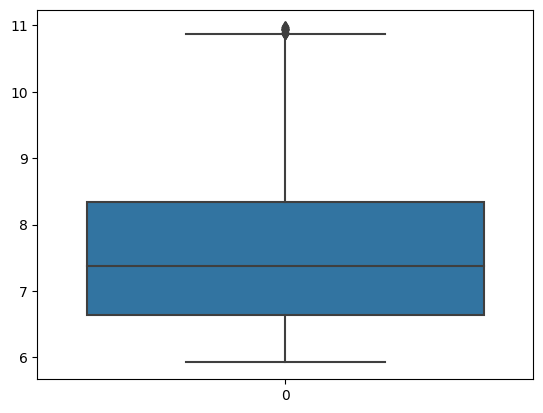

In [38]:
# average of the number of hours worked per day
in_time = in_time.dropna(axis=1, how='all')
out_time = out_time.dropna(axis=1, how='all')
in_time = in_time.dropna(axis=0, how='all')
out_time = out_time.dropna(axis=0, how='all')
in_time = in_time.apply(pd.to_datetime)
out_time = out_time.apply(pd.to_datetime)
hours_worked = out_time - in_time
hours_worked = hours_worked.applymap(lambda x: x.total_seconds() / 3600)
hours_worked = hours_worked.mean(axis=1)
hours_worked = hours_worked.dropna()
hours_worked = hours_worked.reset_index(drop=True)
sns.boxplot(hours_worked)



In [39]:
hours_worked_df = pd.DataFrame({
    "EmployeeID": general["EmployeeID"],
    "avg_hours_worked": hours_worked })
hours_worked_df

,EmployeeID,avg_hours_worked
0,1,7.342004
1,2,7.686399
2,3,6.984379
3,4,7.163197
4,5,7.973629
...,...,...
4405,4406,8.487350
4406,4407,6.067777
4407,4408,7.673414
4408,4409,9.453369


On remarque un taux plus élevé de démissions chez les gens qui travaillent le plus

<Axes: xlabel='avg_hours_worked', ylabel='Count'>

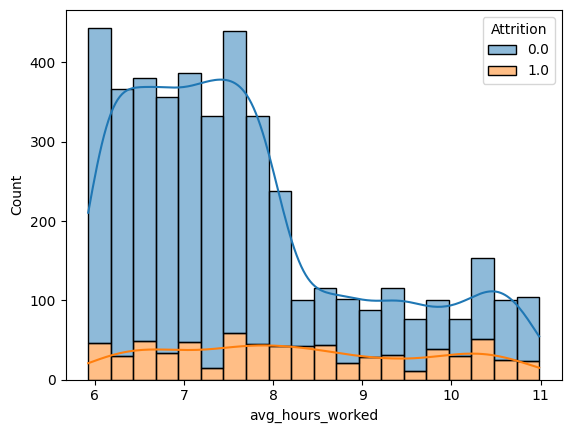

In [40]:
general_time = general.merge(hours_worked_df, on="EmployeeID")

sns.histplot(data=general_time, x="avg_hours_worked", hue="Attrition", multiple="stack", bins=20, kde=True)

In [41]:
general_badAll = general_time.merge(BadAll, on="EmployeeID", copy=True)

(general_badAll["Attrition"] == 0).sum()

133

### Heure moyenne de départ

In [42]:
out_timeAverage = out_time[out_time.columns[1:]].apply(pd.to_datetime)
out_timeAverage = out_timeAverage.apply(lambda x: (x - x.dt.normalize()).dt.total_seconds() / 3600)
out_timeAverage  = out_timeAverage.mean(axis=1)
out_timeAverage = out_timeAverage.to_frame()
out_timeAverage = out_timeAverage.assign(EmployeeID=range(1, len(out_timeAverage)+1))
out_timeAverage = out_timeAverage.rename(columns={0: 'avg_out_time'})

### Heure moyenne d'arrivé

In [43]:
in_timeAverage = in_time[in_time.columns[1:]].apply(pd.to_datetime)
in_timeAverage = in_timeAverage.apply(lambda x: (x - x.dt.normalize()).dt.total_seconds() / 3600)
in_timeAverage = in_timeAverage.mean(axis=1)
in_timeAverage = in_timeAverage.to_frame()
in_timeAverage = in_timeAverage.assign(EmployeeID=range(1, len(in_timeAverage)+1))
in_timeAverage = in_timeAverage.rename(columns={0:'AverageStartTime'})

## Fusion des differents dataframes

In [93]:
all_data = general.merge(manager_survey, on="EmployeeID", copy=True)
all_data = all_data.merge(employee_survey, on="EmployeeID", copy=True)
all_data = all_data.merge(hours_worked_df, on="EmployeeID", copy=True)
all_data = all_data.merge(out_timeAverage, on="EmployeeID", copy=True)
all_data = all_data.merge(in_timeAverage, on="EmployeeID", copy=True)

## Data cleaning

On regarde si certaines données peuvent être supprimées.
Pour cela on regarde les données contenues dans les colonnes "Over18", "StandardHours" et "EmployeeNumber" et on remarque qu'elles sont toutes les mêmes pour chaque employé, donc on peut les supprimer. Pour ce qui est de "EmployeeID" on sait que c'est un identifiant unique pour chaque employé donc on peut aussi le supprimer.

In [95]:
print("EmployeeID :" , all_data["EmployeeID"].unique())
print("Over18 :",all_data["Over18"].unique())
print("StandardHours :",all_data["StandardHours"].unique())
print("EmployeeCount :",all_data["EmployeeCount"].unique())

EmployeeID : [   1    2    3 ... 4408 4409 4410]
Over18 : [1.]
StandardHours : [8]
EmployeeCount : [1]


On défini donc une fonction qui nous permet dans un premier temps de supprimer les colonnes inutiles, et dans un second temps de supprimer les données qui on un impacte éthique sur les employés.

In [108]:
def dataCleaning(all_data, type):
    if type == 1:
        # drop useless columns
        all_data.drop("EmployeeID", axis=1, inplace=True)
        all_data.drop("Over18", axis=1, inplace=True)
        all_data.drop("EmployeeCount", axis=1, inplace=True)
        all_data.drop("StandardHours", axis=1, inplace=True)

    if type == 2:
        # drop unethical columns
        all_data.drop("Male", axis=1, inplace=True)
        all_data.drop("Female", axis=1, inplace=True)
        all_data.drop("Single", axis=1, inplace=True)
        all_data.drop("Married", axis=1, inplace=True)
        all_data.drop("Divorced", axis=1, inplace=True)
        all_data.drop("Age", axis=1, inplace=True)

    return all_data

all_data = dataCleaning(all_data,1)

Lien entre age et temps travaillé

In [109]:
all_data = dataCleaning(all_data,2)

## Gestion des valeurs manquantes

In [110]:
def nullToMedian(all_data):
    all_data["NumCompaniesWorked"] = all_data["NumCompaniesWorked"].replace(np.nan,median(all_data["NumCompaniesWorked"]))
    all_data["TotalWorkingYears"] = all_data["TotalWorkingYears"].replace(np.nan,median(all_data["TotalWorkingYears"]))

    all_data["EnvironmentSatisfaction"] = all_data["EnvironmentSatisfaction"].replace(np.nan,median(all_data["EnvironmentSatisfaction"]))
    all_data["JobSatisfaction"] = all_data["JobSatisfaction"].replace(np.nan,median(all_data["JobSatisfaction"]))
    all_data["WorkLifeBalance"] = all_data["WorkLifeBalance"].replace(np.nan,median(all_data["WorkLifeBalance"]))
    return all_data

def nullToKnnImputer(all_data):
    imputer = KNNImputer(n_neighbors=5)
    all_data_imputed = pd.DataFrame(imputer.fit_transform(all_data), columns=all_data.columns)
    return all_data_imputed

all_data = nullToKnnImputer(all_data)

# Standardisation des données

In [111]:
# Liste des colonnes à standardiser
columns_to_standardize = ["TotalWorkingYears", "YearsSinceLastPromotion", "YearsWithCurrManager", "MonthlyIncome", "YearsAtCompany", "TrainingTimesLastYear"]

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Supprimer les valeurs aberrantes en utilisant la méthode IQR
for col in columns_to_standardize:
    all_data = remove_outliers_iqr(all_data, col)

## Normalisation des données

In [112]:
min_max_scaler = lambda x: (x-x.min()) / (x.max()-x.min())
all_data = all_data.apply(min_max_scaler)
all_data

,Attrition,BusinessTravel,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,...,Job_Sales Executive,Job_Sales Representative,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,avg_hours_worked,avg_out_time,AverageStartTime
0,1.0,1.0,0.321429,0.00,0.00,0.307828,0.000000,0.857143,0.333333,0.352941,...,0.0,0.0,0.333333,1.0,0.666667,0.333333,1.000000,0.345989,0.345239,0.360231
1,0.0,0.5,0.321429,0.00,0.00,0.126643,0.444444,0.071429,0.666667,0.529412,...,1.0,0.0,0.666667,0.0,1.000000,0.000000,0.666667,0.403140,0.403960,0.434548
2,1.0,0.5,0.357143,0.25,0.25,0.467138,0.222222,0.642857,0.333333,0.294118,...,1.0,0.0,0.666667,1.0,0.000000,0.666667,0.000000,0.188292,0.183602,0.190093
3,0.0,0.5,0.607143,0.50,0.25,0.205219,0.222222,0.785714,1.000000,0.588235,...,1.0,0.0,0.666667,1.0,0.000000,0.333333,0.666667,0.149333,0.152143,0.464690
4,0.0,0.5,0.000000,0.50,0.00,0.151167,0.111111,0.214286,0.000000,0.294118,...,0.0,0.0,0.666667,0.0,1.000000,1.000000,0.333333,0.023275,0.027814,0.505856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006,0.0,1.0,0.714286,0.00,0.50,0.121444,0.444444,0.142857,0.000000,0.529412,...,0.0,0.0,0.333333,0.0,0.000000,0.666667,0.666667,0.400349,0.401285,0.437362
2007,1.0,1.0,0.035714,0.50,0.00,0.289386,0.666667,0.000000,0.333333,1.000000,...,0.0,0.0,0.666667,0.0,0.000000,0.666667,0.666667,0.225710,0.227502,0.435514
2008,0.0,0.5,0.107143,0.50,0.25,0.244065,0.111111,0.500000,0.000000,0.352941,...,0.0,0.0,0.333333,0.0,0.666667,1.000000,0.666667,0.261728,0.263464,0.443534
2009,0.0,0.5,0.035714,0.75,0.00,0.159702,0.222222,0.285714,0.000000,0.588235,...,0.0,0.0,0.333333,0.0,1.000000,1.000000,0.666667,0.023923,0.027621,0.475596


## Selection des caractéristiques et split de nos données

Le test du khi2 permet d'identifier les caractéristiques les plus pertinentes pour un modèle en évaluant leur indépendance par rapport à la variable cible.

In [113]:
# Préparer les données
y = all_data["Attrition"]
X = all_data.drop(columns=["Attrition"])

# Diviser les données en ensembles d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

In [114]:
# Sélection des caractéristiques avec le test du khi2
k_best = SelectKBest(chi2, k="all")  # Utilisez un nombre approprié pour 'k' en fonction de vos données
X_train_kbest = k_best.fit_transform(x_train, y_train)
X_test_kbest = k_best.transform(x_test)

In [116]:
# Choisir un modèle (ici, nous utilisons la régression logistique)
model = LogisticRegression()

# Liste pour stocker les scores de validation croisée
cv_scores = []

In [117]:
max_features = x_train.shape[1]

# Boucle sur différentes valeurs de k
for k in range(1, max_features + 1):
    # Sélection des k meilleures caractéristiques
    k_best = SelectKBest(chi2, k=k)
    X_train_kbest = k_best.fit_transform(x_train, y_train)
    
    # Évaluation du modèle avec validation croisée k-fold (k = 5)
    scores = cross_val_score(model, X_train_kbest, y_train, cv=5)
    mean_score = np.mean(scores)
    cv_scores.append(mean_score)

# Trouver la valeur de k avec la meilleure performance
best_k = np.argmax(cv_scores) + 1
print(f"La meilleure valeur de k est {best_k}")

La meilleure valeur de k est 32


Nous avons donc déterminé que la valeur optimale de k est 32, nous garderons donc les 32 caractéristiques les plus importantes. Déterminons maintenant nos données finales à utiliser dans nos modèles.

In [118]:
# Sélection des caractéristiques avec le test du khi2
k_best = SelectKBest(chi2, k=best_k)
X_train_kbest = k_best.fit_transform(x_train, y_train)
X_test_kbest = k_best.transform(x_test)

# Récupérer les noms de colonnes sélectionnés
selected_features = x_train.columns[k_best.get_support()]

In [119]:
# Convertir les tableaux NumPy en DataFrames pandas avec les noms de colonnes appropriés
x_train = pd.DataFrame(X_train_kbest, columns=selected_features)
x_test = pd.DataFrame(X_test_kbest, columns=selected_features)

# Analyse et relation entre nos données

<Axes: >

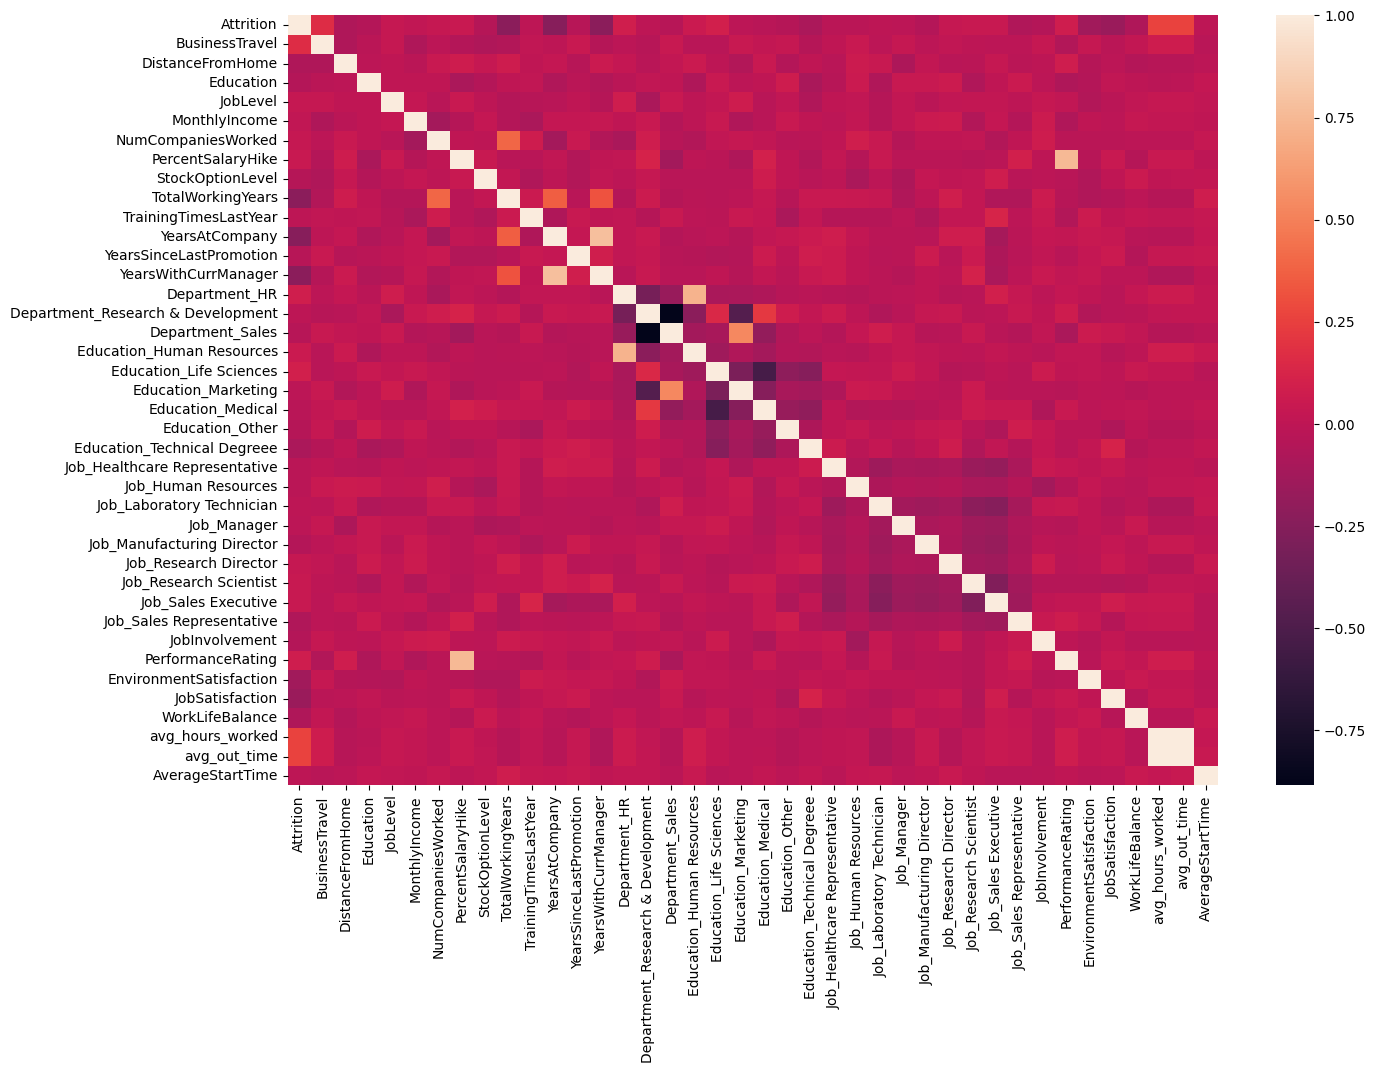

In [120]:
plt.figure(figsize=(15, 10))
sns.heatmap(all_data.corr())

<Axes: >

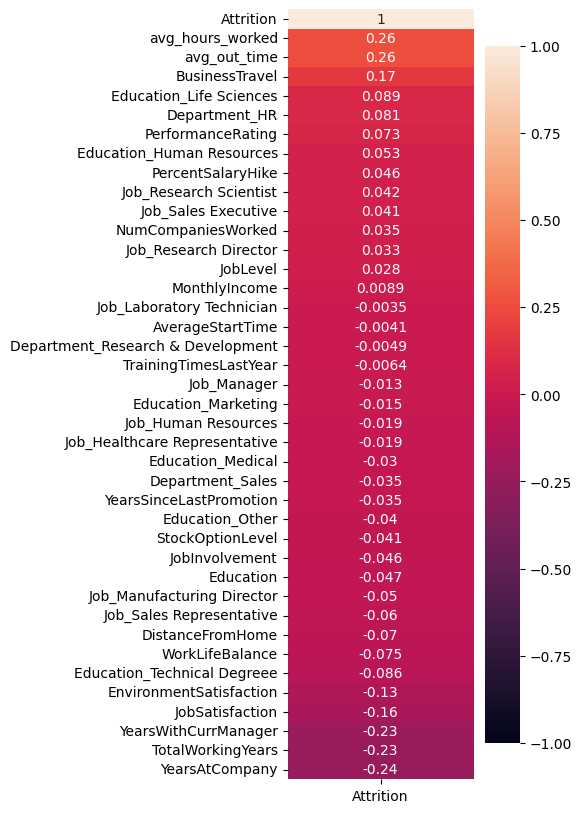

In [121]:
plt.figure(figsize=(3, 10))
all_data_corr = all_data.corr()
sns.heatmap(all_data_corr[['Attrition']].sort_values(by=['Attrition'],ascending=False), vmin=-1, vmax=1, annot=True)

# Test des différents modèles

On défini d'abord une fonction qui nous permettra d'étudier les résultats de nos modèles.
On calculs dans un premier temps différents scores :
* __Accuracy (Précision globale)__ : C'est le rapport entre le nombre total de prédictions correctes et le nombre total d'observations. Elle permet d'évaluer la performance globale d'un modèle de classification. Accuracy = (True Positives + True Negatives) / (Total des observations)

* __Precision (Précision)__ : C'est le rapport entre les vrais positifs et la somme des vrais positifs et des faux positifs. La précision mesure la proportion de prédictions positives qui sont réellement positives. Precision = (True Positives) / (True Positives + False Positives)

* __Recall (Rappel)__ : C'est le rapport entre les vrais positifs et la somme des vrais positifs et des faux négatifs. Le rappel mesure la proportion de vraies valeurs positives qui ont été correctement identifiées. Recall = (True Positives) / (True Positives + False Negatives)

* __F1 Score (Score F1)__ : C'est la moyenne harmonique de la précision et du rappel. Le score F1 tient compte à la fois de la précision et du rappel et donne un équilibre entre les deux. Un score F1 élevé indique un bon équilibre entre la précision et le rappel. F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

* __AUC (Area Under Curve - Aire sous la courbe)__ : L'AUC est une métrique utilisée pour évaluer la performance d'un modèle de classification binaire en fonction de sa courbe ROC (Receiver Operating Characteristic). La courbe ROC trace le taux de vrais positifs en fonction du taux de faux positifs. L'AUC mesure la capacité d'un modèle à distinguer entre les classes positives et négatives. Un AUC de 1 indique une performance parfaite, tandis qu'un AUC de 0,5 indique une performance aléatoire.

Ensuite on affiche la courbe ROC afin d'obtenir une mesure global de la performance des modèles.

In [122]:
def score(y_test, y_pred):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 score:", f1_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("ROC AUC score:", roc_auc_score(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_score(y_test, y_pred))
    roc_display.plot()
    plt.show()

Maintenant que nos données sont prêtes à être exploitées par les différents modèles, il nous faut les choisir. Puisque notre situation est un problème de classification binaires, nous avons décider de tester les modèles suivants :

* Regression logistique
* Arbre de descision
* Forêt aléatoire
* Hist Gradient Boosting Classifier
* Perceptron

## Choix des hyperparamètres

### DecisionTreeClassifier

Pour le DecisionTreeClassifier nous allons utiliser GridSearch afin de trouver les meilleurs hyperparamètres

In [123]:
pipeline_dtc = Pipeline(steps=[
    ('classifier', DecisionTreeClassifier())
])

In [124]:
criterion = ['gini', 'entropy']
max_depth = [16,18,20,21,22,23,24,30]
splitter = ['best','random']


parameters_dtc = dict(classifier__criterion=criterion,
                  classifier__max_depth=max_depth,
                  classifier__splitter=splitter)


In [125]:
dtc_GS = GridSearchCV(pipeline_dtc, parameters_dtc, cv=7)
dtc_GS.fit(x_train, y_train)

dtc_GS.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 18,
 'classifier__splitter': 'random'}

In [126]:
pd.DataFrame.from_dict(dtc_GS.cv_results_).sort_values(by=['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
3,0.004500,0.000600,0.001287,0.000452,gini,18,random,"{'classifier__criterion': 'gini', 'classifier_...",0.972851,0.990909,0.990909,0.972727,0.986364,0.977273,0.986364,0.982485,0.007438,1
1,0.003718,0.000455,0.001426,0.000498,gini,16,random,"{'classifier__criterion': 'gini', 'classifier_...",0.959276,0.986364,0.990909,0.986364,0.954545,0.986364,1.000000,0.980546,0.015656,2
13,0.004430,0.000477,0.001854,0.000349,gini,24,random,"{'classifier__criterion': 'gini', 'classifier_...",0.977376,0.995455,0.977273,0.972727,0.972727,0.981818,0.986364,0.980534,0.007566,3
29,0.005071,0.001265,0.001859,0.000639,entropy,24,random,"{'classifier__criterion': 'entropy', 'classifi...",0.981900,0.977273,0.977273,0.968182,0.986364,0.977273,0.990909,0.979882,0.006814,4
23,0.003866,0.000625,0.001713,0.000443,entropy,21,random,"{'classifier__criterion': 'entropy', 'classifi...",0.981900,0.972727,0.981818,0.968182,0.981818,0.977273,0.990909,0.979233,0.006815,5


Accuracy: 0.9963369963369964
F1 score: 0.9913043478260869
Precision: 0.9827586206896551
Recall: 1.0
ROC AUC score: 0.9976851851851851


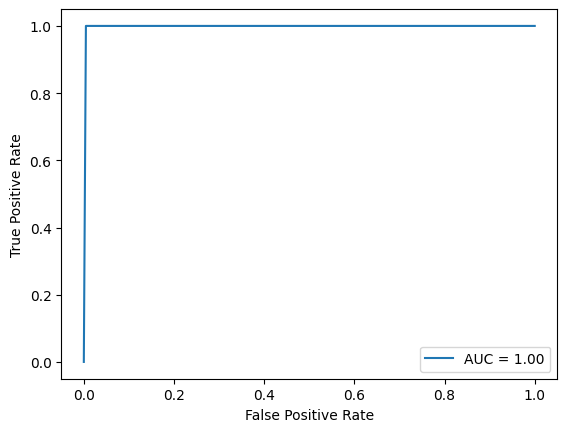

In [127]:
dtc = DecisionTreeClassifier(criterion = dtc_GS.best_params_['classifier__criterion'], max_depth = dtc_GS.best_params_['classifier__max_depth'], splitter = dtc_GS.best_params_['classifier__splitter'])

dtc.fit(x_train, y_train)

y_pred_dtc = dtc.predict(x_test)

score(y_test, y_pred_dtc)

Après plusieurs tests, on ressort qu'une max_depth de 22 et un criterion en entropy est le meilleur model que l'on peu avoir

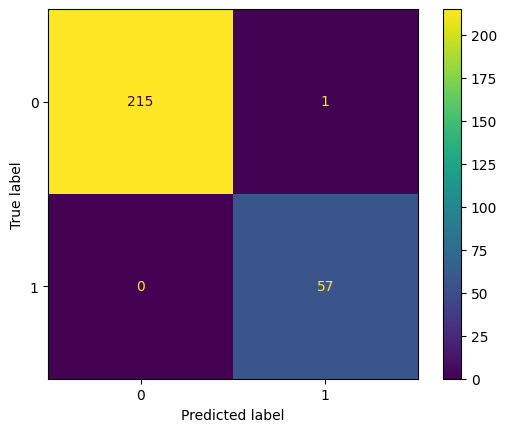

In [128]:
dtc_cm = confusion_matrix(y_test, y_pred_dtc)
dtc_cmd = ConfusionMatrixDisplay(confusion_matrix=dtc_cm,
                       display_labels=[0,1])

dtc_cmd.plot()
plt.show()


### HistGradientBoostingClassifier

In [129]:
pipeline_hgbc = Pipeline(steps=[
    ('classifier', HistGradientBoostingClassifier())
])

In [130]:
learning_rate = [0.1,0.2,0.3]
max_depth = [10,15,20,30]
loss = ['log_loss']
max_iter = [10,20,50,100,200]

parameters_hgbc = dict(classifier__learning_rate=learning_rate,
                  classifier__max_depth=max_depth,
                  classifier__loss=loss,
                  classifier__max_iter=max_iter
                  )

In [131]:
hgbc_GS = GridSearchCV(pipeline_hgbc, parameters_hgbc)
hgbc_GS.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('classifier',
                                        HistGradientBoostingClassifier())]),
             param_grid={'classifier__learning_rate': [0.1, 0.2, 0.3],
                         'classifier__loss': ['log_loss'],
                         'classifier__max_depth': [10, 15, 20, 30],
                         'classifier__max_iter': [10, 20, 50, 100, 200]})

In [132]:
pd.DataFrame.from_dict(hgbc_GS.cv_results_).sort_values(by=['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__loss,param_classifier__max_depth,param_classifier__max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
24,2.633505,0.042031,0.013505,0.000446,0.2,log_loss,10,200,"{'classifier__learning_rate': 0.2, 'classifier...",0.990291,0.977273,0.974026,0.993506,1.0,0.987019,0.00985,1
33,1.630947,0.042437,0.008031,0.000579,0.2,log_loss,20,100,"{'classifier__learning_rate': 0.2, 'classifier...",0.990291,0.974026,0.977273,0.993506,1.0,0.987019,0.00985,1
34,2.720149,0.130092,0.014306,0.000874,0.2,log_loss,20,200,"{'classifier__learning_rate': 0.2, 'classifier...",0.990291,0.974026,0.977273,0.993506,1.0,0.987019,0.00985,1
38,1.605071,0.012345,0.008000,0.000633,0.2,log_loss,30,100,"{'classifier__learning_rate': 0.2, 'classifier...",0.990291,0.974026,0.977273,0.993506,1.0,0.987019,0.00985,1
39,2.581805,0.069716,0.012997,0.000632,0.2,log_loss,30,200,"{'classifier__learning_rate': 0.2, 'classifier...",0.990291,0.974026,0.977273,0.993506,1.0,0.987019,0.00985,1


Accuracy: 1.0
F1 score: 1.0
Precision: 1.0
Recall: 1.0
ROC AUC score: 1.0


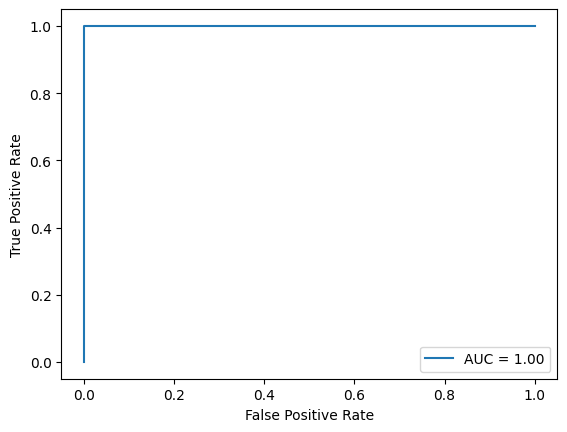

In [133]:
hgbc = HistGradientBoostingClassifier(learning_rate = hgbc_GS.best_params_['classifier__learning_rate'],max_depth= hgbc_GS.best_params_['classifier__max_depth'], max_iter=hgbc_GS.best_params_['classifier__max_iter'], loss=hgbc_GS.best_params_['classifier__loss'])

hgbc.fit(x_train, y_train)
y_pred_hgbc = hgbc.predict(x_test)

score(y_test, y_pred_hgbc)

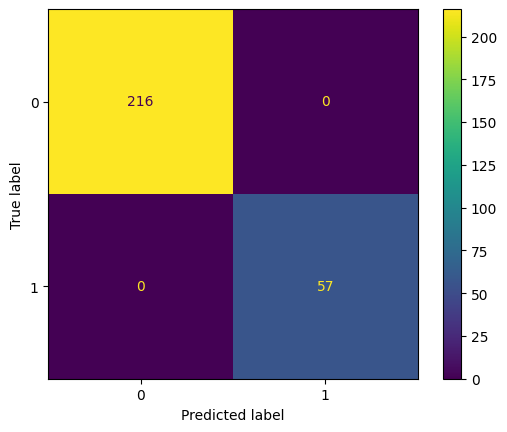

In [134]:
cm_hgbc = confusion_matrix(y_test, y_pred_hgbc)
cmd_hgbc = ConfusionMatrixDisplay(confusion_matrix=cm_hgbc,
                       display_labels=[0,1])

cmd_hgbc.plot()
plt.show()

### RandomForestClassifier

In [135]:
pipeline_rfc = Pipeline(steps=[
    ('classifier', RandomForestClassifier())
])

In [136]:
n_estimators = [1,2,3,5,10,50,100,200,300]
criterion = ['gini', 'entropy']
max_depth = [5,10,14,18,22,24,30,50,100]


parameters_rfc = dict(classifier__n_estimators=n_estimators,
                  classifier__criterion=criterion,
                  classifier__max_depth=max_depth
                  )

In [137]:
rfc_GS = GridSearchCV(pipeline_rfc, parameters_rfc)
rfc_GS.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [5, 10, 14, 18, 22, 24, 30,
                                                   50, 100],
                         'classifier__n_estimators': [1, 2, 3, 5, 10, 50, 100,
                                                      200, 300]})

In [138]:
pd.DataFrame.from_dict(rfc_GS.cv_results_).sort_values(by=['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
80,0.616960,0.005309,0.030634,0.001679,gini,100,300,"{'classifier__criterion': 'gini', 'classifier_...",0.990291,0.980519,0.980519,0.983766,1.000000,0.987019,0.007407,1
78,0.208959,0.002555,0.011110,0.000760,gini,100,100,"{'classifier__criterion': 'gini', 'classifier_...",0.990291,0.980519,0.983766,0.980519,0.996753,0.986370,0.006300,2
59,0.108435,0.004518,0.006710,0.000624,gini,30,50,"{'classifier__criterion': 'gini', 'classifier_...",0.990291,0.980519,0.980519,0.983766,0.996753,0.986370,0.006300,3
116,0.666997,0.011439,0.030331,0.000951,entropy,18,300,"{'classifier__criterion': 'entropy', 'classifi...",0.987055,0.980519,0.977273,0.983766,1.000000,0.985723,0.007848,4
143,0.747902,0.043956,0.032644,0.001632,entropy,30,300,"{'classifier__criterion': 'entropy', 'classifi...",0.990291,0.980519,0.977273,0.980519,1.000000,0.985721,0.008370,5


Accuracy: 1.0
F1 score: 1.0
Precision: 1.0
Recall: 1.0
ROC AUC score: 1.0


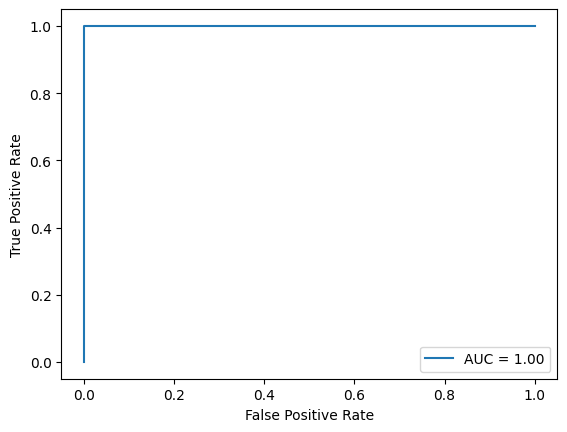

In [139]:
rfc = RandomForestClassifier(n_estimators=rfc_GS.best_params_['classifier__n_estimators'],criterion=rfc_GS.best_params_['classifier__criterion'],max_depth=rfc_GS.best_params_['classifier__max_depth'])

rfc.fit(x_train, y_train)
y_pred_rfc = rfc.predict(x_test)

score(y_test, y_pred_rfc)

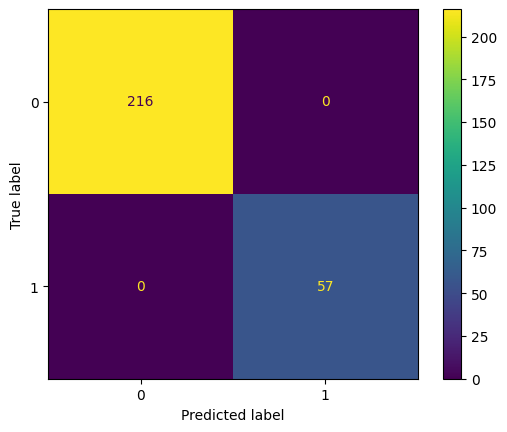

In [140]:
cm_rfc = confusion_matrix(y_test, y_pred_rfc)
cmd_rfc = ConfusionMatrixDisplay(confusion_matrix=cm_rfc,
                       display_labels=[0,1])

cmd_rfc.plot()
plt.show()

### Perceptron

In [141]:
pipeline_pe = Pipeline(steps=[
    ('classifier', Perceptron())
])

In [142]:
penalty = ['l2','l1','elasticnet']
alpha = [0.0001,0.0002,0.0003,0.0005]


parameters_pe = dict(classifier__penalty=penalty,
                  classifier__alpha=alpha)


In [143]:
pe_GS = GridSearchCV(pipeline_pe, parameters_pe)
pe_GS.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('classifier', Perceptron())]),
             param_grid={'classifier__alpha': [0.0001, 0.0002, 0.0003, 0.0005],
                         'classifier__penalty': ['l2', 'l1', 'elasticnet']})

In [144]:
pd.DataFrame.from_dict(pe_GS.cv_results_).sort_values(by=['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,0.004403,0.001359,0.002600,0.000798,0.0003,l2,"{'classifier__alpha': 0.0003, 'classifier__pen...",0.760518,0.844156,0.792208,0.827922,0.788961,0.802753,0.029776,1
7,0.011202,0.002400,0.002601,0.000800,0.0003,l1,"{'classifier__alpha': 0.0003, 'classifier__pen...",0.663430,0.837662,0.834416,0.847403,0.821429,0.800868,0.069219,2
9,0.003805,0.000738,0.001771,0.000386,0.0005,l2,"{'classifier__alpha': 0.0005, 'classifier__pen...",0.818770,0.720779,0.827922,0.775974,0.805195,0.789728,0.038690,3
5,0.007591,0.001490,0.002003,0.000005,0.0002,elasticnet,"{'classifier__alpha': 0.0002, 'classifier__pen...",0.669903,0.805195,0.801948,0.834416,0.814935,0.785279,0.058788,4
1,0.009223,0.002796,0.002794,0.000739,0.0001,l1,"{'classifier__alpha': 0.0001, 'classifier__pen...",0.634304,0.818182,0.785714,0.834416,0.821429,0.778809,0.074011,5


Accuracy: 0.8168498168498168
F1 score: 0.37500000000000006
Precision: 0.6521739130434783
Recall: 0.2631578947368421
ROC AUC score: 0.6130604288499025


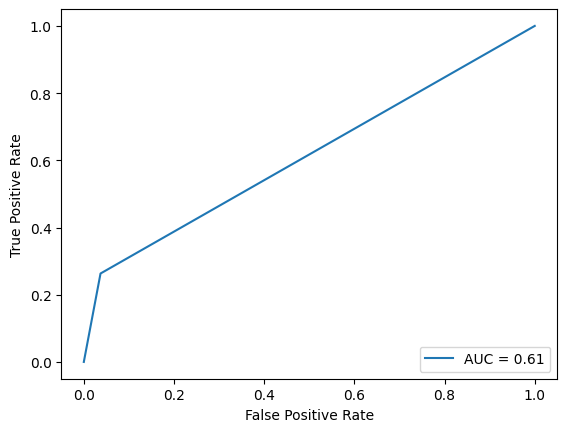

In [145]:
pe = Perceptron(penalty=pe_GS.best_params_['classifier__penalty'],alpha = pe_GS.best_params_['classifier__alpha'])

pe.fit(x_train, y_train)
y_pred_pe = pe.predict(x_test)

score(y_test, y_pred_pe)

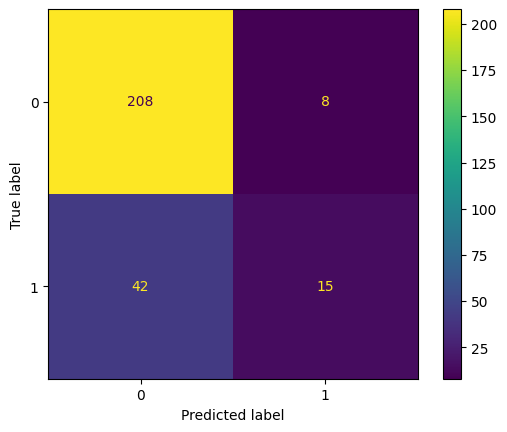

In [146]:
cm_pe = confusion_matrix(y_test, y_pred_pe)
cmd_pe = ConfusionMatrixDisplay(confusion_matrix=cm_pe,
                       display_labels=[0,1])

cmd_pe.plot()
plt.show()

### Logistic Regression

In [147]:
pipeline_lr = Pipeline(steps=[
    ('classifier', LogisticRegression())
])

In [148]:
penalty = ['l2']
max_iter = [100,500,1000]


parameters_lr = dict(classifier__penalty = penalty,
                  classifier__max_iter = max_iter)

In [149]:
lr_GS = GridSearchCV(pipeline_lr, parameters_lr)
lr_GS.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('classifier', LogisticRegression())]),
             param_grid={'classifier__max_iter': [100, 500, 1000],
                         'classifier__penalty': ['l2']})

In [150]:
pd.DataFrame.from_dict(lr_GS.cv_results_).sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_iter,param_classifier__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.032013,0.003890,0.002000,0.000633,100,l2,"{'classifier__max_iter': 100, 'classifier__pen...",0.828479,0.837662,0.857143,0.86039,0.831169,0.842969,0.01328,1
1,0.029722,0.001717,0.001906,0.000188,500,l2,"{'classifier__max_iter': 500, 'classifier__pen...",0.828479,0.837662,0.857143,0.86039,0.831169,0.842969,0.01328,1
2,0.028538,0.003823,0.001800,0.000401,1000,l2,"{'classifier__max_iter': 1000, 'classifier__pe...",0.828479,0.837662,0.857143,0.86039,0.831169,0.842969,0.01328,1


Accuracy: 0.8534798534798534
F1 score: 0.5652173913043478
Precision: 0.7428571428571429
Recall: 0.45614035087719296
ROC AUC score: 0.7072368421052633


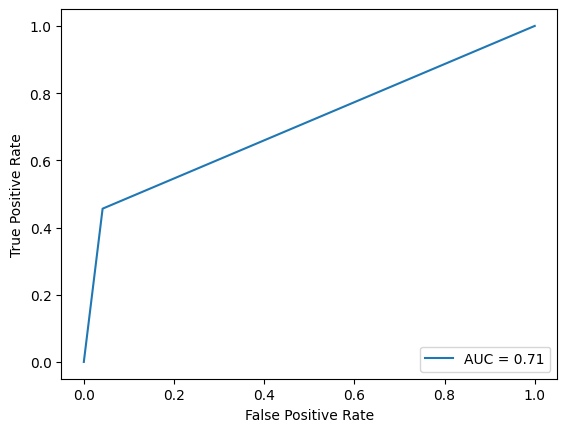

In [151]:
lr = LogisticRegression(penalty=lr_GS.best_params_['classifier__penalty'], max_iter=lr_GS.best_params_['classifier__max_iter'] )

lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)

score(y_test, y_pred_lr)

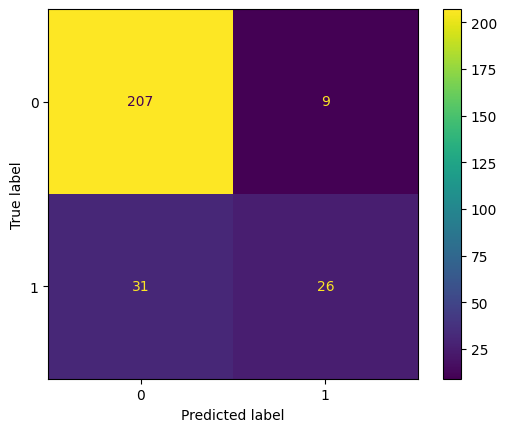

In [152]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
cmd_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr,
                       display_labels=[0,1])

cmd_lr.plot()
plt.show()

# Analyse des résultats

### DecisionTreeClassifier

In [153]:
cl_dtc = list(zip(x_train.columns, dtc.feature_importances_))
coefs_dtc = pd.DataFrame(cl_dtc, columns = ['Column', 'Coefs'])
coefs_dtc.sort_values(by=['Coefs'], ascending=False)

,Column,Coefs
31,avg_out_time,0.113926
7,TotalWorkingYears,0.106963
29,WorkLifeBalance,0.062900
3,JobLevel,0.050238
9,YearsSinceLastPromotion,0.050125
8,YearsAtCompany,0.048736
0,BusinessTravel,0.047885
4,NumCompaniesWorked,0.043950
14,Education_Life Sciences,0.041682
1,DistanceFromHome,0.040223


### HistGradientBoostingClassifier

L'analyse des résutats d'un HistGradientBoostingClassifier est complexe car ce modèle est capable de capturer des relations non-linéaires entre nos differentes données.
Il est donc difficile de comprendre comment ces relations non-linéaires contribuent à la prédiction du modèle.

### RandomForestClassifier

In [154]:
cl_rfc = list(zip(x_train.columns, rfc.feature_importances_))
coefs_rfc= pd.DataFrame(cl_rfc, columns = ['Column', 'Coefs'])
coefs_rfc.sort_values(by=['Coefs'], ascending=False)


,Column,Coefs
30,avg_hours_worked,0.115364
31,avg_out_time,0.111647
7,TotalWorkingYears,0.091941
8,YearsAtCompany,0.069084
1,DistanceFromHome,0.058001
5,PercentSalaryHike,0.057142
4,NumCompaniesWorked,0.051705
10,YearsWithCurrManager,0.046146
27,EnvironmentSatisfaction,0.045323
28,JobSatisfaction,0.040261


### Perceptron

In [155]:
cl_pe = list(zip(x_train.columns, pe.coef_[0]))
coefs_pe = pd.DataFrame(cl_pe, columns = ['Column', 'Coefs'])
coefs_pe.sort_values(by=['Coefs'], ascending=False)

,Column,Coefs
31,avg_out_time,4.296517
30,avg_hours_worked,4.230284
0,BusinessTravel,3.624472
14,Education_Life Sciences,2.588762
4,NumCompaniesWorked,2.471341
20,Job_Manager,1.974599
5,PercentSalaryHike,1.498125
9,YearsSinceLastPromotion,1.103345
22,Job_Research Director,0.969809
15,Education_Medical,0.613963


### LogisticRegression

In [156]:
cl_lr = list(zip(x_train.columns, lr.coef_[0]))
coefs_lr = pd.DataFrame(cl_lr, columns = ['Column', 'Coefs'])
coefs_lr.sort_values(by=['Coefs'], ascending=False)

,Column,Coefs
0,BusinessTravel,1.497422
31,avg_out_time,1.410121
30,avg_hours_worked,1.409680
11,Department_HR,1.256866
22,Job_Research Director,1.252265
4,NumCompaniesWorked,1.073712
14,Education_Life Sciences,0.756672
23,Job_Research Scientist,0.528588
24,Job_Sales Executive,0.458580
26,PerformanceRating,0.444036


# Conclusion
<div id="cc"></div>

Le choix du modèle de machine learning dépend de nombreux facteurs tels que la taille et la qualité des données, le type de problème à résoudre et les objectifs de performance. Dans le cas présent, nous avons éliminé HistGradientBoostingClassifier en raison de son manque d'interprétabilité, et le perceptron ainsi que la régression logistique en raison de résultats inexploitables.

Finalement, le DecisionTreeClassifier a été choisi comme modèle car il est plus facile à comprendre que le RandomForestClassifier. Il est donc plus facile d'expliquer les relations possibles entre nos différentes données et donc de proposer des pistes d'amélioration pour réduire le turn over.

## Etudes pour HumanForYou

Dans cette partie, nous proposons plusieurs pistes d'amélioration pour aider HumanForYou à réduire 
son taux de turn-over et à améliorer la satisfaction des employés. Nos recommandations sont basées 
sur l'analyse des données fournies et les modèles développés dans le respect des principes éthiques

In [157]:
coefs_dtc.sort_values(by=['Coefs'], ascending=False).head(4)

,Column,Coefs
31,avg_out_time,0.113926
7,TotalWorkingYears,0.106963
29,WorkLifeBalance,0.062900
3,JobLevel,0.050238


### Opportunités de formation et de développement professionnel
Le nombre de jours de formation et les années depuis la dernière promotion (YearsSinceLastPromotion) sont des facteurs 
influençant le taux de turn-over. Il est essentiel d'offrir des opportunités de formation et de 
développement professionnel pour maintenir l'engagement des employés. HumanForYou pourrait 
mettre en place un programme de formation continue et un système de mentorat pour soutenir les 
employés dans leur évolution professionnelle.
### Amélioration de l'équilibre travail-vie personnelle
Les données montrent que le temps passé au travail (avg_hours_worked & avg_out_time) est un facteur important 
pour la satisfaction des employés. L'entreprise pourrait proposer des options de travail flexibles, 
comme le télétravail, des horaires ajustables ou la mise en place d'un système de crédit-temps pour 
encourager une meilleure conciliation entre la vie professionnelle et personnelle.
### Satisfaction de l'environnement de travail 
Les employés qui se sentent satisfaits de leur environnement de travail (EnvironmentSatisfaction) sont plus susceptibles de 
rester dans l'entreprise. HumanForYou devrait examiner les conditions de travail, les installations et 
les équipements pour s'assurer qu'ils sont bien adaptés aux besoins des employés. Des enquêtes 
régulières sur la qualité de vie au travail peuvent aider à identifier les domaines à améliorer.

En mettant en œuvre ces pistes d'amélioration, HumanForYou peut créer un environnement de 
travail plus attrayant et réduire le taux de turn-over. Il est important de suivre régulièrement 
l'efficacité de ces initiatives et d'ajuster les stratégies en conséquence, en tenant compte des retours 
des employés et des nouvelles informations issues de l'analyse des données

## Pistes d'amélioration
- Afin d'avoir un pipline plus conséquent et détaillé à l'avenir.
- Utiliser les méthodes SHAP pour meusurer la transparence des différents modèles.
- Utiliser des algorithmes potentiellement plus avancées au détriment de la transparence dui modèle.